In [1]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score
print("scikit-learn version: {}". format(sklearn.__version__))

import lightgbm as lgb
print("LightGBM version:  {}".format(lgb.__version__))

import matplotlib
import matplotlib.pyplot as plt
print("Matplotlib version:  {}".format(matplotlib.__version__))

import seaborn as sns
print("Seaborn version:  {}".format(sns.__version__))

import optuna
print("Optuna version:  {}".format(optuna.__version__))

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

scikit-learn version: 0.23.2


LightGBM version:  3.2.1
Matplotlib version:  3.4.3
Seaborn version:  0.11.2
Optuna version:  2.9.1
/kaggle/input/tabular-playground-series-sep-2021/train.csv
/kaggle/input/tabular-playground-series-sep-2021/test.csv
/kaggle/input/tabular-playground-series-sep-2021/sample_solution.csv


In [2]:
# read input files
df_train = pd.read_csv("../input/tabular-playground-series-sep-2021/train.csv")
df_test = pd.read_csv("../input/tabular-playground-series-sep-2021/test.csv")
sample_submission = pd.read_csv("../input/tabular-playground-series-sep-2021/sample_solution.csv")

feature_cols = [col for col in df_train.columns if col.startswith("f")]
target=df_train.claim

In [3]:
# adding the magic feature, see https://www.kaggle.com/c/tabular-playground-series-sep-2021/discussion/270206
df_train['NaNs'] = df_train[feature_cols].isna().sum(axis=1)
df_test['NaNs'] = df_test[feature_cols].isna().sum(axis=1)
feature_cols += ['NaNs']
# feature_cols.append('NaNs') #alternative statement

In [4]:
# preprocessing pipeline
new_features = ['NaNs']
numeric_features = [col for col in df_train.columns if col.startswith("f")]

numeric_transformer = Pipeline(steps=[
       #('imputer', SimpleImputer(strategy='mean')), # replace all Nan with mean
       ('scaler', PowerTransformer()) # scale the features
        ]) 

second_transformer = Pipeline(steps=[
       #('imputer', SimpleImputer(strategy='mean')), 
       ('scaler', StandardScaler(with_mean=False, with_std=False)) # this pipeline does intentionally nothing
        ]) 

preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features),
    ('second', second_transformer, new_features)
   ]) 

prepare for Optuna (not used in this run)

In [5]:
kfolds = KFold(n_splits=4, shuffle=True, random_state=7)

In [6]:
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=1) 

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    return params

In [7]:
def lgb_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 100, 2000) 
    _learning_rate = trial.suggest_float("learning_rate", 1e-6, 0.3, log=True)
    _min_child_weight = trial.suggest_float("min_child_weight", 1e-3, 16) #min_sum_hessian_in_leaf, default 1e-3
    _min_child_samples = trial.suggest_int("min_child_samples", 10, 30) #min_data_in_leaf, default 20
    _subsample = trial.suggest_float('subsample', 0.6, 1) #bagging_fraction, default 1.0, needs bagging_freq to be non zero
    _colsample_bytree = trial.suggest_float('colsample_bytree', 0.7, 1) #feature_fraction, default 1.0
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10, log=True)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10, log=True)

    
    model = lgb.LGBMClassifier(
        objective = 'binary', 
        n_estimators=_n_estimators,
        learning_rate=_learning_rate,
        min_child_weight=_min_child_weight,
        min_child_samples =_min_child_samples,
        subsample=_subsample,
        subsample_freq=10,#bagging_freq, default 0,
        colsample_bytree=_colsample_bytree,
        reg_alpha=_reg_alpha,
        reg_lambda=_reg_lambda,
        random_state=7
    )
    

    val_metric = []
    for train_index, test_index in kfolds.split(X):
 
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
        model.fit( 
            X_train, 
            y_train,
            eval_set=[(X_val, y_val)],
            eval_names=['val'],
            eval_metric='auc',
            early_stopping_rounds=50, 
            verbose=100)
    
        pred_val = model.predict_proba(X_val)[:,1]
    
    val_metric.append(roc_auc_score(y_val, pred_val)) 
    
   
    score = sum(val_metric)/len(val_metric) 
    
    return score

In [8]:

#X = preprocessor.fit_transform(df_train[feature_cols])
#y = df_train.claim

In [9]:
#X= pd.DataFrame(data=X, columns=feature_cols)

In [10]:
# start optuna here
#lgbm_params_tuned = tune(lgb_objective)
#lgbm_params_tuned

In [11]:
# dividing X, y into train and test data
X = df_train[feature_cols]
y = df_train.claim
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 29, stratify=y)
display(X_train.shape)

(718439, 119)

In [12]:
X_train1 = preprocessor.fit_transform(X_train)
X_val1 = preprocessor.transform(X_val)
#X_test = preprocessor.transform(df_test[feature_cols])

In [13]:
# most of the parameters I borrowed from BIZENs great notebook: https://www.kaggle.com/hiro5299834/tps-sep-2021-single-lgbm
lgb_params = {
    'objective': 'binary',
    'metric' : 'auc',
    'n_estimators': 2000,
    'random_state': 29,
    'learning_rate': 0.1,
    'subsample': 0.6,
    'subsample_freq': 1,
    'colsample_bytree': 0.4,
    'reg_alpha': 10.0,
    'reg_lambda': 1e-1,
    'min_child_weight': 256,
    'min_child_samples': 20,
}

In [14]:
model = lgb.LGBMClassifier(**lgb_params)
model.fit( 
        X_train1, 
        y_train,
        eval_set=[(X_train1, y_train),(X_val1, y_val)],
        eval_names=['train','val'],
        eval_metric='auc',
        early_stopping_rounds=200, 
        verbose=100)

Training until validation scores don't improve for 200 rounds
[100]	train's auc: 0.820083	val's auc: 0.811321
[200]	train's auc: 0.827992	val's auc: 0.813768
[300]	train's auc: 0.833979	val's auc: 0.814164
[400]	train's auc: 0.839454	val's auc: 0.814185
[500]	train's auc: 0.844514	val's auc: 0.814069
Early stopping, best iteration is:
[323]	train's auc: 0.835332	val's auc: 0.814289


LGBMClassifier(colsample_bytree=0.4, metric='auc', min_child_weight=256,
               n_estimators=2000, objective='binary', random_state=29,
               reg_alpha=10.0, reg_lambda=0.1, subsample=0.6, subsample_freq=1)

In [15]:
# original data
# with metric auc
#[525]	train's auc: 0.845909	val's auc: 0.814188
# with no metric specified
# [331]	train's auc: 0.835894	train's binary_logloss: 0.495533	val's auc: 0.814072	val's binary_logloss: 0.5077
# using preprocessed data
# with no metric specified
#[317]	train's auc: 0.834971	train's binary_logloss: 0.496104	val's auc: 0.814287	val's binary_logloss: 0.507658
# with metric auc
#[323]	train's auc: 0.835332	val's auc: 0.814289

In [16]:
pred_val = model.predict_proba(X_val1)[:,1]
#pred_val[0:5] 
roc_auc_score(y_val, pred_val)

0.8142886031131762

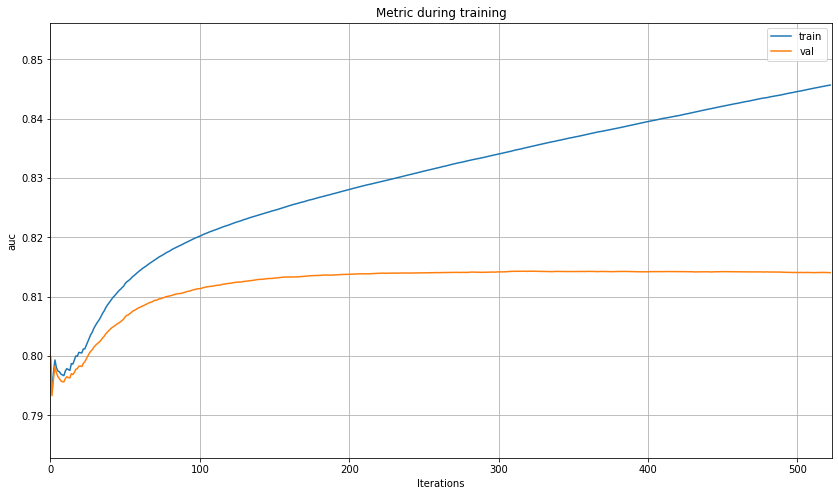

In [17]:
lgb.plot_metric(model, metric="auc", figsize=(14,8))
plt.show()

In [18]:
#model.feature_importances_

In [19]:
#model.feature_name_

In [20]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,feature_cols)), columns=['Value','Feature'])
feature_imp = feature_imp.sort_values(by="Value", ascending=False)

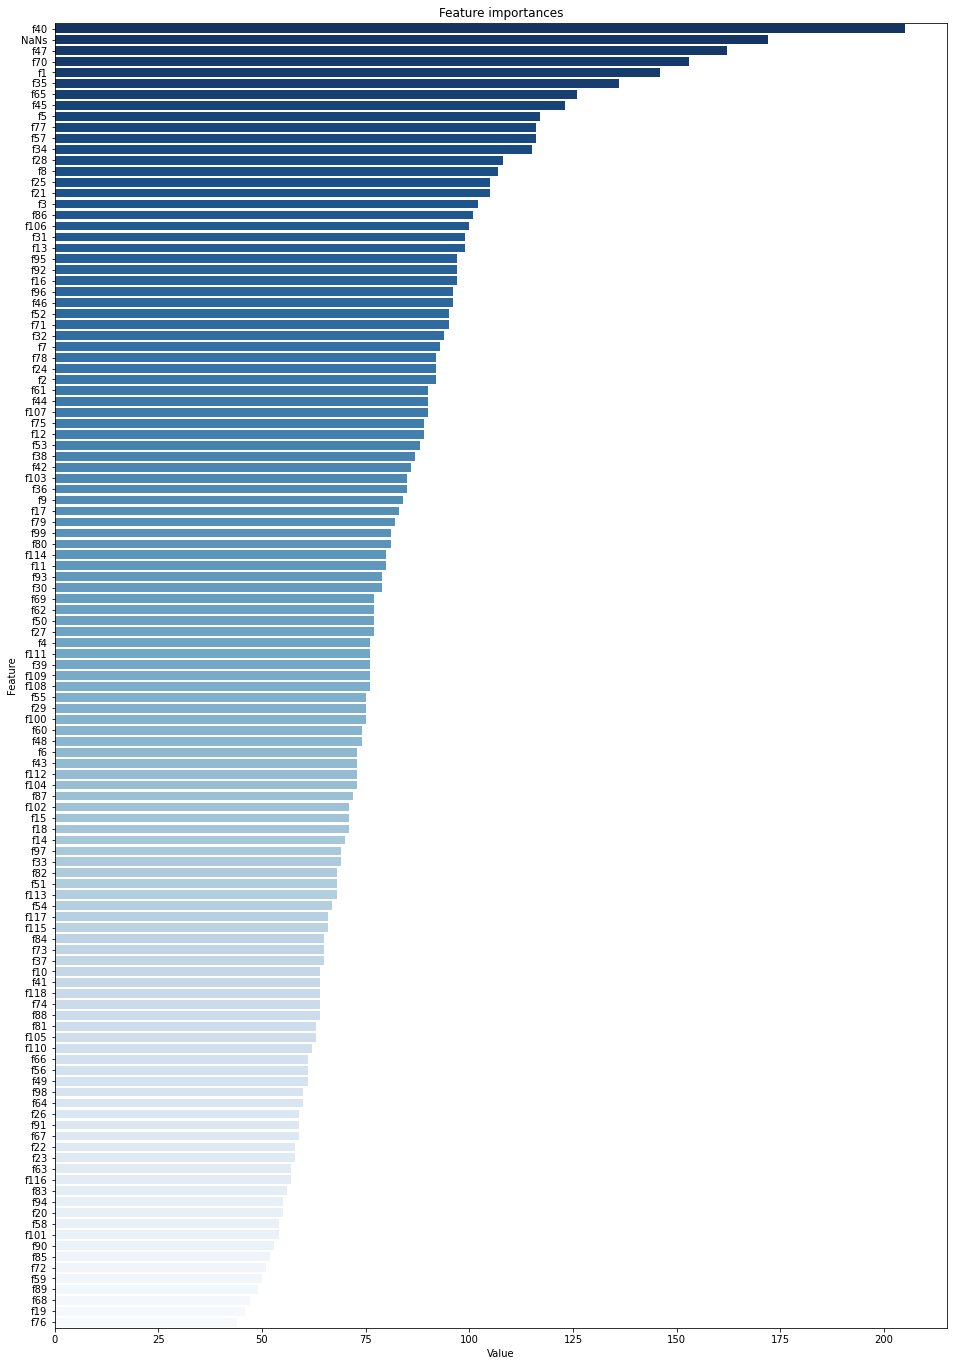

In [21]:
plt.figure(figsize=(16,24))
sns.barplot(x=feature_imp.Value, y=feature_imp.Feature, palette="Blues_r")
plt.title("Feature importances")
plt.show()

In [22]:
#lgb.plot_importance(model, figsize=(16,24))
#plt.show()

# in the current lighgbm version this plot has Column_39 as y_tick names instead of the actual feature name

In [23]:
# transform test set and predict for test set
X_test = preprocessor.transform(df_test[feature_cols])
predictions = model.predict_proba(X_test)[:,1]

In [24]:
# generate submission file 
submission_lgbm = pd.DataFrame(data={"id" : sample_submission.id,
                                     "claim" : predictions})

submission_lgbm.to_csv('submission_lgbm.csv', index=False)
submission_lgbm.head()

,id,claim
0,957919,0.656690
1,957920,0.126173
2,957921,0.645718
3,957922,0.119288
4,957923,0.141103
